In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfb = tfp.bijectors
tf.config.set_visible_devices([], 'GPU')


In [2]:
from filterflow.smc import SMC
from filterflow.base import State, StateWithMemory, StateSeries

from filterflow.observation.base import ObservationModelBase, ObservationSampler
from filterflow.observation.linear import LinearObservationSampler
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition.base import TransitionModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

from filterflow.constants import MIN_ABSOLUTE_WEIGHT

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

try:
    df = pd.read_csv(url)
except:
    data_dir = "../../data/covid"
    df = pd.read_csv(os.path.join(data_dir, 'covid.csv'))

df.dateRep = pd.to_datetime(df.dateRep, dayfirst=True)
df_clean = df.loc[(df.geoId.isin(['UK'])) & (df.deaths>0)].sort_values('dateRep')

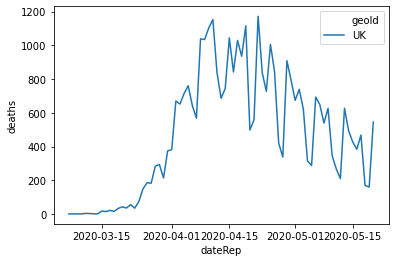

In [4]:
seaborn.lineplot(data=df_clean, x='dateRep', y='deaths', hue='geoId')

Infections model (Latent state evolution):
\begin{align}
    S_t &= S_{t-1}-\beta S_{t-1}I_{t-1}/N \\
    E_t &= (1-\alpha)E_{t-1}+\beta S_{t-1} I_{t-1}/N \\
    I_t &= (1-\gamma+\epsilon_t) I_{t-1}+\alpha E_{t-1}\\
    R_t &= R_{t-1} + \gamma I_{t-1}  ~\mathbf{\text{not needed}}\\
    \epsilon_t &\sim \mathcal{N}(0,1)\\
\end{align}

Death Model (Observation Model):
\begin{align}
d_t &= \delta_t I_t \\
    D_t - D_{t-1} &\sim \text{NegBinom}(d_t, d_t + \frac{d_t^2}{\Psi}) \\
    \Psi &\sim \mathcal{N}^+(0,5)
\end{align}

In [5]:
def split_sei(x):
    S, E, I = tf.split(x, 3, axis=-1)
    return S,E,I

def join_sei(S,E,I):
    x = tf.concat([S,E, I], axis=-1)
    return x

    


In [6]:
alpha = 0.45
beta = 0.45
gamma = 0.15
delta = 0.001
log_sig = np.float32(np.log(0.1))
population_size = 66488991.0

In [7]:
class SEIRTransitionModel(TransitionModelBase):
    def __init__(self, alpha, beta, gamma, log_sig, population_size, name='SEIRTransitionModel'):
        super(SEIRTransitionModel, self).__init__(name=name)
        
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.log_sig = log_sig
        self.pop = population_size
        self.normal_dist = tfp.distributions.Normal(loc=tf.constant(0.), scale=tf.exp(log_sig))
        
    def _loglikelihood(self, prior_state: State, proposed_state: State):
        St_1, Et_1, It_1 = split_sei(prior_state.particles)
        St, Et, It = split_sei(proposed_state.particles)
        
        eps = (It - (1.-self.gamma)*It_1 - self.alpha*Et_1) / It_1
        log_prob = tf.reduce_sum(self.normal_dist.log_prob(eps), axis=-1)
        return log_prob
    
    def loglikelihood(self, prior_state: State, proposed_state: State, inputs: tf.Tensor):
        return self._loglikelihood(prior_state, proposed_state)

    def sample(self, state: State, inputs: tf.Tensor):
        St_1, Et_1, It_1 = split_sei(state.particles)
        
        eps = self.normal_dist.sample()
        
        St = St_1 - self.beta*St_1*It_1/self.pop
        Et = (1-self.alpha) * Et_1 + self.beta*St_1*It_1/self.pop

        It = (1-self.gamma+eps)*It_1 + self.alpha*Et_1
        
        x = join_sei(St, Et, It)
        
        return State(particles=x, 
                     log_weights = state.log_weights,
                     weights=state.weights, 
                     log_likelihoods=state.log_likelihoods)

In [8]:
class SEIRProposalModel(SEIRTransitionModel):
    def __init__(self, alpha, beta, gamma, log_sig, population_size, name ='SEIRProposalModel'):
        super(SEIRProposalModel, self).__init__(alpha, beta, gamma, log_sig, population_size, name=name)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        return self._loglikelihood(state, proposed_state)
    
    def propose(self, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        return self.sample(state, None)

In [9]:
class SEIRObservationModel(ObservationSampler):
    
    def __init__(self, delta, batch_shape=50, name='SEIRObservationModel'):
        super(SEIRObservationModel, self).__init__(name=name)
        self.half_norm_dist = tfp.distributions.HalfNormal(scale = tf.constant(5.))
        self.delta = delta
        self.batch_shape = batch_shape
    
    def get_dist(self, state: State):
        S, E, I = split_sei(state.particles)
        b = state.batch_size
        dt = self.delta*I
        pois_dist = tfp.distributions.Poisson(rate = dt)
        #tf.print('Mean deaths', dt)
        return pois_dist
    
    def loglikelihood(self, state: State, observation: tf.Tensor):
    
        pois_dist = self.get_dist(state)
        prob = tf.reduce_sum(pois_dist.prob(observation), axis=-1)
        
        #tf.print('Obs',observation)
        #tf.print('Prob',prob)
        return prob

    def sample(self, state: State):
        pois_dist = self.get_dist(state)
        d = pois_dist.sample()
        return d

In [10]:
batch_size = 2
n_particles = 4
dimension = 1


In [11]:
learnable_alpha = tf.Variable(alpha, trainable=True)
learnable_beta = tf.Variable(beta, trainable=True)
learnable_gamma = tf.Variable(gamma, trainable=True)
learnable_delta = tf.Variable(gamma, trainable=True)

transition_model = SEIRTransitionModel(learnable_alpha, learnable_beta, learnable_gamma, log_sig, population_size)
proposal_model = SEIRProposalModel(learnable_alpha, learnable_beta, learnable_gamma, log_sig, population_size)
observation_model = SEIRObservationModel(delta)

In [12]:
trainable_variables = [learnable_alpha, learnable_beta, learnable_gamma]

In [13]:
S0 = population_size-1.
I0 = 1.
E0 = 0.

initial_sei = tf.constant([S0,E0,I0])
initial_sei = tf.reshape(initial_sei, [1, 1, 3])
initial_particles = tf.tile(initial_sei, [batch_size, n_particles, 1])

In [14]:

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

In [15]:
df = df_clean
observations = df[df.geoId == 'UK']['deaths'].iloc[::-1].values.astype(np.float32)
obs_data = tf.data.Dataset.from_tensor_slices(observations.reshape(-1, 1, 1, 1))

In [16]:
T = observations.shape[0]

In [17]:
obs = observation_model.sample(initial_state)

In [18]:
observation_model.loglikelihood(initial_state, obs)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.9990005, 0.9990005, 0.9990005, 0.9990005],
       [0.9990005, 0.9990005, 0.9990005, 0.9990005]], dtype=float32)>

In [19]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

In [20]:
regularized_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, multinomial)

In [21]:
res = particle_filter(initial_state, obs_data, T, return_final=False).particles

In [22]:
# Create an optimizer.


LR = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [50, 150], [0.025, 0.01, 0.005]
)


optimizer = tf.optimizers.Adam(learning_rate=LR, epsilon=1e-8)

In [23]:
@tf.function
def smc_routine(smc, state, use_correction_term=False):
    final_state = smc(initial_state, 
                      observation_series=obs_data, 
                      n_observations=T, 
                      return_final=True)

    res = tf.reduce_mean(final_state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(final_state.resampling_correction)
    return res, tf.constant(0.)
    

@tf.function
def run_one_step(smc, use_correction_term, init_state):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    return real_ll, grads_loss


@tf.function
def train_one_step(smc, use_correction_term):
    real_ll, grads_loss = run_one_step(smc, use_correction_term, initial_state)
    clip = lambda x: tf.clip_by_value(x, -500., 500.)
    grads_loss = [clip(grad) for grad in grads_loss]
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return -real_ll, grads_loss


@tf.function
def train_niter(smc, num_steps=100, use_correction_term=False, reset=True):
    reset_trainable_variables = [learnable_alpha.assign(alpha), 
                                 learnable_beta.assign(beta), 
                                 learnable_gamma.assign(gamma)]
    if reset:
        reset_operations = reset_trainable_variables
    else:
        reset_operations = []

    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            loss, grads = train_one_step(smc, use_correction_term)

            toc = tf.timestamp()
            max_grad = tf.reduce_max(tf.abs(grads))
            if True:
                tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ': total time (s)= ', (toc - tic), ', loss = ', loss, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step-1, loss)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
            
            #tf.print(learnable_alpha, learnable_beta, learnable_gamma)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()
            
@tf.function
def train_total_time(smc, total_time, use_correction_term=False, reset=True):
    reset_trainable_variables = [learnable_alpha.assign(alpha), 
                                 learnable_beta.assign(beta), 
                                 learnable_gamma.assign(gamma)]
    if reset:
        reset_operations = reset_trainable_variables
    else:
        reset_operations = []
        
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        toc = tic
        step = tf.constant(1)
        while toc - tic < total_time:
            loss, grads = train_one_step(smc, use_correction_term)
            max_grad = tf.reduce_max(tf.abs(grads))
            loss_tensor_array = loss_tensor_array.write(step-1, loss)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
            step = step + 1

            toc = tf.timestamp()

            tf.print('Time elapsed (s): ', toc-tic, ', n_steps: ', step, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), end='\r')
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()


@tf.function
def run_several(smc, n_times, use_correction_term=False):
    loss_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False, element_shape=[])
    grad_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False)
    for i in tf.range(n_times):
        real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
        loss_array = loss_array.write(i, real_ll)        
        grad_array = grad_array.write(i, grads_loss)
        tf.print('Step: ', i+1, '/', n_times, end='\r')
    return loss_array.stack(), grad_array.stack()

In [24]:
num_iter = 200

In [25]:
reg_loss_tensor_array, reg_grad_tensor_array, reg_time_tensor_array = train_niter(regularized_filter, tf.constant(num_iter), False)

In [26]:
reg_loss = reg_loss_tensor_array.numpy()

In [27]:
trainable_variables

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.3155185>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.43237174>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.21001533>]

In [28]:
optimizer.set_weights([w * 0 for w in optimizer.get_weights()])

In [29]:
loss_tensor_array, grad_tensor_array, time_tensor_array = train_niter(particle_filter, tf.constant(num_iter), False)

In [30]:
multi_loss = loss_tensor_array.numpy()

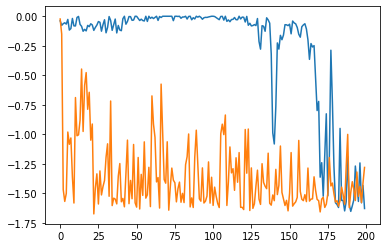

In [35]:
plt.plot(multi_loss)
plt.plot(reg_loss)

In [32]:
trainable_variables

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.35777563>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.4178511>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.2048777>]

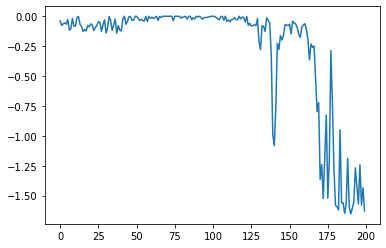

In [33]:
plt.plot(multi_loss)

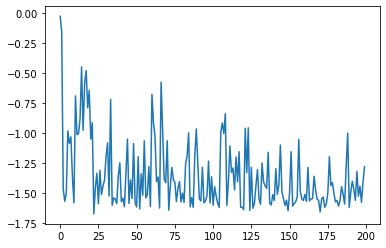

In [34]:
plt.plot(reg_loss)